In [2]:
import gym 
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Environment

In [3]:
import IPython

env = gym.make('Acrobot-v1')
env.reset()

#[cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2]
observation_space = env.observation_space
print(observation_space)

#The action is either applying +1, 0 or -1 torque on the joint between the two pendulum links.
action_space = env.action_space
print(action_space)

array([ 0.9994587 ,  0.03289993,  0.9963384 ,  0.08549695, -0.01116561,
       -0.09660595], dtype=float32)

In [4]:
image = env.render(mode="rgb_array")
env.close()

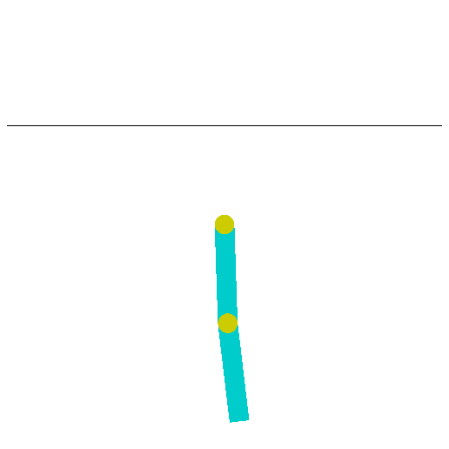

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize = (8, 8))
plt.axis('off')
plt.imshow(image)
plt.show()

## Model

In [9]:
import random
import numpy as np

import torch
from torch import nn
from tools import ReplayMemory

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_space_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64 * 2),
            nn.ReLU(),
            nn.Linear(64 * 2, action_space_dim)
        )

    def forward(self, x):
        x = x.to(device)
        return self.model(x)

In [23]:
class Agent:

    def __init__(self, env):
        self.env = env
        # Init models
        self.replay_mem = ReplayMemory(MEMORY)

        state_space_dim = env.observation_space.shape[0]
        action_space_dim = env.action_space.n

        # Initialize models
        self.main_net = DQN(state_space_dim, action_space_dim).to(device)
        self.target_net = DQN(state_space_dim, action_space_dim).to(device)
        self.target_net.load_state_dict(self.main_net.state_dict())

        # Initialize the optimizer
        self.optimizer = torch.optim.Adam(self.main_net.parameters(), lr=LR)

        # Initialize the loss function
        self.loss_fn = nn.SmoothL1Loss()

    def update_target_network(self):
        print('Updating target network...')
        self.target_net.load_state_dict(self.main_net.state_dict())

    def save_current_state(self, path):
        torch.save(self.main_net.state_dict(), path)

    def load_current_state(self, path):
        self.main_net.load_state_dict(torch.load(path))
        self.target_net.load_state_dict(torch.load(path))



In [24]:
def get_best_action(self, state, eps):

        with torch.no_grad():
            self.main_net.eval()
            state = torch.tensor(state, dtype=torch.float32)  # Convert the state to tensor
            net_out = self.main_net(state)

        # Get the best action (argmax of the network output)
        best_action = int(net_out.argmax())
        action_space_dim = net_out.shape[-1]

        # Select a non optimal action with probability epsilon, otherwise choose the best action
        if random.random() < eps:
            non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
            action = random.choice(non_optimal_actions)
        else:
            action = best_action

        return action, net_out.cpu().numpy()

setattr(Agent, 'get_best_action', get_best_action)

In [25]:
def get_action(self, state, eps):

    if eps == 0:
        return self.get_best_action(state, 0)

    with torch.no_grad():
        self.main_net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = self.main_net(state)

    eps = max(eps, 1e-8)
    softmax_out = nn.functional.softmax(net_out / eps, dim=0).cpu().numpy()

    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out)

    return action, net_out.cpu().numpy()

setattr(Agent, 'get_action', get_action)

In [26]:
def update_step(self):
    global GAMMA, BATCH_SIZE

    # Sample the data from the replay memory
    batch = self.replay_mem.sample(BATCH_SIZE)
    BATCH_SIZE = len(batch)

    # Create tensors for each element of the batch
    states = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32, device=device)
    actions = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64, device=device)
    rewards = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32, device=device)
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)

    # Compute all the Q values (forward pass)
    self.main_net.train()
    q_values = self.main_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        self.target_net.eval()
        q_values_target = self.target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * GAMMA)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)  # Set the required tensor shape

    # Compute the Huber loss
    loss = self.loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(self.main_net.parameters(), 2)
    self.optimizer.step()

setattr(Agent, 'update_step', update_step)

In [27]:
def step(self, state, eps):
    # Choose the action
    action, q_values = self.get_action(state, eps)

    # Apply the action and get the next state, reward and done
    next_state, reward, done, _ = self.env.step(action)

    # Apply penalty for bad state
    if done:  # if the pole has fallen down
        # reward += bad_state_penalty
        next_state = None

    # Update the replay memory
    self.replay_mem.push(state, action, next_state, reward)

    # we enable the training only if we have enough samples in the replay memory,
    # otherwise the training will use the same samples too often
    if len(self.replay_mem) > MIN_SAMPLES_FOR_TRAINING:
        self.update_step()

    return next_state, reward, done

setattr(Agent, 'step', step)

## Training

In [16]:
# CONFIG

GAMMA = 0.99  # gamma parameter for the long term reward
MEMORY = 10000  # Replay memory capacity
LR = 1e-3 # learning rate for Adam
BATCH_SIZE = 256 

NET_UPDATE_SPET = 10  # Number of episodes to wait before updating the target network
NET_SAVE_STEP = 100
MIN_SAMPLES_FOR_TRAINING = 1000

INIT_EXP_DELAY_VALUE = 5
NUM_EPISODES = 800

# Exponential decay
exp_decay = np.exp(-np.log(INIT_EXP_DELAY_VALUE) / NUM_EPISODES * 6)  # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [INIT_EXP_DELAY_VALUE * (exp_decay ** i) for i in range(NUM_EPISODES)]


In [ ]:
env = gym.make('Acrobot-v1')
env.seed(0)  # Set a random seed for the environment (reproducible results)

agent = Agent(env)

plotting_rewards = []

for episode, eps in enumerate(exploration_profile):

    state = env.reset()
    score = 0
    done = False

    while not done:

        next_state, reward, done = agent.step(state, eps)

        score += reward
        state = next_state

        # env.render()

    # Update the target network every target_net_update_steps episodes
    if episode % NET_UPDATE_SPET == 0:
        agent.update_target_network()

    if episode % NET_SAVE_STEP == 0:
        agent.save_current_state(f"model/model_{episode}.pth")

    plotting_rewards.append(score)
    print(f"Episode: {episode + 1}, Score: {score}, Eps: {eps}")
        
env.close()

In [ ]:
agent.save_current_state("model/model.pth")

## Test

In [28]:
agent = Agent(env)
agent.load_current_state("model/model.pth")

In [29]:
mean_reward = 0

TESTS_COUNT = 20
for i in range(TESTS_COUNT):
    state = env.reset()
    score = 0
    done = False
    
    while not done:
        next_state, reward, done = agent.step(state, 0)

        score += reward
        state = next_state
    
    mean_reward += score
    
print(f"Mean score: {mean_reward / TESTS_COUNT}")

Mean score: -74.95


In [32]:
import time

state = env.reset()
score = 0
done = False

while not done:
    next_state, reward, done = agent.step(state, 0)

    score += reward
    state = next_state

    env.render()
    time.sleep(0.03)

In [33]:
env.close()